<script type="text/x-mathjax-config">
  MathJax.Hub.Config({tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}});
</script>
<script type="text/javascript"
  src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML">
</script>

*The codes were developed on Windows 10, and were not tested on other machines. Anaconda 5.2.0 is chosen as a Python interpreter.*

This notebook introduces the concept and methodology of implementing Bootstrap Simulation.

# Non-Parametric Confidence Intervals with Bootstrap

> **Bootstrap** is a non-parametric statistical technique to resample from known samples to estimate uncertainty in summary statistics. When there are small, limited number of samples, it gives a more accurate forecast model than directly obtaining a forecast model from the limited sample pool (assuming that the sample set of data is reasonable representation of the population). It is non-parametric because it does not require any prior knowledge of the distribution (shape, mean, standard devation, etc..).


** Advantages of Bootstrap **

One great thing about Bootstrapping is that it is **distribution-free**. You do not need to know distribution shape, mean, standard devation, skewness, kurtosis, etc... All you need is just a set of sample data that is representative of a population. The fact that Bootstrapping does not depend on a type of distribution leads to another great advantage - **It can calculate uncertainty in any confidence interval of any kind of distribution**. 

For example, the analytical solution to calculate a confidence interval in any statistics of a distribution is as follows:

<p><center>CI of mean = stats of interest $\pm$ $($distribution score $\times$ Standard Error $)$</center></p>

There are three problems with analytically solving for confidence interval of a statistic.

First, the variable in the equation, *distribution score*, depends on the type of the distribution. If you do not know the distribution shape of your population, it is very difficult to calculate the confidence interval of a statistic. 

Second, not all statistics have a formula to calculate its *Standard Error*. For example, there exists an equation to calculate the standard error of a mean:

<p><center>Standard Error = $\sigma_{sample} \  \mathbin{/} \ \sqrt{N}$</center></p>

But there is no equation to calculate the standard error of a median. If you want to obtain confidence intervals for other statistics (ex: skewness, kurtosis, IQR, etc...), it will be very difficult to do so, simply because there are no equations for them.

Third, some statistics have analytical solutions for its standard error calculation, but it is so convoluted that Bootstrapping is simpler. A classic example is obtaining a CI for the correlation coefficient given a sample from a bivariate normal distribution.

Bootstrapping calculates confidence intervals for summary statistics **numerically, not analytically**, and this is why it can calculate ANY summary stats for ANY distribution. 

** Methodology **

One goal of inferential statistics is to determine the value of a parameter of an entire population. It is typically too expensive or even impossible to measure this directly. So we use statistical sampling. We sample a population, measure a statistic of this sample, and then use this statistic to say something about the corresponding parameter of the population.

Bootstrapping is a type of resampling method to save time and money taking measurements. From a sample pool of size N, it picks a random value N times **with replacement**, and create M number of new Bootstrapped-sample pools. The term **with replacement** here means that you put back the sample you drew to the original sample pool after adding it to a new Bootstrapped-sample pool. Think of it this way: you randomly choose a file from a folder in your PC, and you *copy* and paste the randomly-chosen file into a new folder. You do not *cut* and paste the file, but you *copy* and paste the file into a new folder. You will have M number of folders (M is an arbitrary number of your choice), each containing N number of files.

Bootstrapping resamples the original sample pool to generate multiple smaller population of the true population. Each Bootstrap simulation is done by selecting a random value from the sample pool. For example, lets assume that you have the following sample pool of integers:
   
<p><center>Sample Integers = [12, 433, 533, 14, 65, 42, 64]</center></p>

From the sample pool of size N=7, you choose a random value N=7 times, and create a new sample pool of size N=7. In Bootstrap, each newly created sample pool is called a **realization**. You generate many of these realizations, and use them to calculate uncertainties in summary stats.

<p><center>Realization 1 = [12, 533, 533, 533, 12, 14, 42]</center></p>
<p><center>Realization 2 = [65, 14, 14, 65, 433, 64, 14]</center></p>
<p><center>Realization 3 = [433, 64, 533, 14, 14, 64, 12]</center></p>
<p><center>Realization 4 = [14, 65, 65, 433, 533, 42, 12]</center></p>

Notice the duplicate data in the realizations (Ex: 533, 533, 533). Duplicates in realizations exist because each data in realization is randomly chosen from the original sample pool **with replacement**.

<div class="alert alert-info">
    <h4>Warning!</h4>
    <p>It is extremly important that the N size for each Bootstrap realization matches the N size of the original sample pool. 
    <br><br>We use Bootstrap to numerically estimate the confidence interval (CI). It's an alternative tool to analytically solve for CI. Observing how CI is analytically calculated may help one to understand why the value of N is important. Let's take the CI of a mean for example. Recall that the CI of a mean represents how far a sample mean can deviate from the true population mean. </p>
    <img style="width: 50%"  src="https://github.com/aegis4048/Petroleum_Engineering/blob/master/Data%20Analysis/img/confidence_interval_of_mean_demo.png?raw=true"/>
    
    <p>In case of a Gaussian, or Gaussian-like distribution (ex: student-t), the equation to analytically solve for confidence interval of a mean is as follows:</p>
    <p><center style="margin-top: 20px">CI of mean = sample mean $\pm$ $($z-score $\times$ Standard Error $)$</center></p>
    <p><center>Standard Error = $\sigma_{sample} \  \mathbin{/} \ \sqrt{N}$</center></p>
    
where $N$ is the number of measured samples. If you increase the number of samples, the standard error of a mean decreases. This logically makes sense, because the more samples you have, the more accurate the estimation of the true population mean becomes. 

<br><br>The size of each Bootstrap realization, N, works the similar way, except that the random sample in each realization is not from the true population, but from a measured sample pool. Increasing the N-value will falsely make you to calculate smaller confidence interval.

<img style="width: 50%" src="https://github.com/aegis4048/Petroleum_Engineering/blob/master/Data%20Analysis/img/wrong_bootstrap_CI_of_mean_demo.png?raw=true">

<br>It can be observed that the CI obtained by using a wrong N-value for Bootstrap generates narrower CI. As a result, the CI of the sample mean does not cover the true population mean, returning a misleading estimation.
</p>
</div>

In summary, Bootstrapping is used for three reasons:

1. Bootstrap can obtain confidence interval in any statistics.
2. Bootstrap does not assume anything about a distribution.
3. Bootstrap helps when there are too few number of samples.

** Imports **

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook

## 1.A. Confidence Intervals in Summary Stats: US Male Height - Gaussian Distribution

Bootstrap simulation can be run to obtain confidence intervals in various population parameters: mean, stdev, variance, min, or max. In this example, we will work with the height distribution of the US Male population, which tends to be Gaussian. However, the fact that the distribution Gaussian is totally unrelated to Bootstrap simulation, because it does not assume anything about the distribution.

Bootstrapping can give us confidence intervals in any summary statistics like the following:

<div class="alert alert-info">
    <p>By 95% chance, the following statistics will fall within the range of:</p>
    <br><b>Mean : </b>75.2 ~ 86.2, with 80.0 being the average
    <br><b>Standard Deviation : </b>2.3 ~ 3.4 with 2.9 being the average
    <br><b>Min : </b>54.3 ~ 57.2, with 55.2 being the average
    <br><b>Max : </b>77.8 ~ 82.4, with 79.8 being the average
    <br><b>Skew : </b>-0.053 ~ 0.323, with 0.023 being the average</p>    
</div>

###  1.A.0. Bootstrap Scripts

** Bootstrap Simulator **

In [823]:
def bootstrap_simulation(sample_data, num_realizations):
    n = sample_data.shape[0]
    boot = []
    for i in range(num_realizations):
        real = np.random.choice(sample_data.values.flatten(), size=n)
        boot.append(real)
        
    columns = ['Real ' + str(i + 1) for i in range(num_realizations)]
    
    return pd.DataFrame(boot, index=columns).T

** Summary Statistics Calculator **

In [847]:
def calc_sum_stats(boot_df):
    sum_stats = boot_df.describe().T[['mean', 'std', 'min', 'max']]
    sum_stats['median'] = boot_df.median()
    sum_stats['skew'] = boot_df.skew()
    sum_stats['kurtosis'] = boot_df.kurtosis()
    sum_stats['IQR'] = boot_df.quantile(0.75) - boot_df.quantile(0.25)
    return sum_stats.T

** Visualization Script **

In [820]:
def visualize_distribution(dataframe, ax_):
    dataframe = dataframe.apply(lambda x: x.sort_values().values)
    
    for col, label in zip(dataframe, dataframe.columns):
        fit = scipy.stats.norm.pdf(dataframe[col], np.mean(dataframe[col]), np.std(dataframe[col]))
        ax_.plot(dataframe[col], fit)
    ax_.set_ylabel('Probability')

** Generate Confidence Intervals **

In [813]:
def calc_bounds(conf_level):
    
    assert (conf_level < 1), "Confidence level must be smaller than 1"
    
    margin = (1 - conf_level) / 2
    upper = conf_level + margin
    lower = margin
    return margin, upper, lower

def calc_confidence_interval(df_sum_stats, conf_level): 
    
    margin, upper, lower = calc_bounds(conf_level)
    
    conf_int_df = df_sum_stats.T.describe(percentiles=[lower, 0.5, upper]).iloc[4:7, :].T
    conf_int_df.columns = ['P' + str(round(lower * 100, 1)), 'P50', 'P' + str(round(upper * 100, 1))]
    return conf_int_df 

def print_confidence_interval(conf_df, conf_level):
    print('By {}% chance, the following statistics will fall within the range of:\n'.format(round(conf_level * 100, 1)))
    
    margin, upper, lower = calc_bounds(conf_level)
    
    upper_str = 'P' + str(round(upper * 100, 1))
    lower_str = 'P' + str(round(lower * 100, 1))
    
    for stat in conf_df.T.columns:
        lower_bound = round(conf_df[lower_str].T[stat], 1)
        upper_bound = round(conf_df[upper_str].T[stat], 1)

        mean = round(conf_df['P50'].T[stat], 1)
        print("{0:<10}: {1:>10}  ~ {2:>10} , AVG = {3:>5}".format(stat, lower_bound, upper_bound, mean))

### 1.A.1 Sample Data Description

100 samples of US male height data is provided in **sample_data/US_Male_Height.csv**. Summary statistics of the sample data can be calculated. Your goal is to calculate the confidence intervals for the summary stats.

In [849]:
# height data

height_data = pd.read_csv('sample_data/US_Male_Height.csv')
height_data.index = ['Male ' + str(i + 1) for i in range(height_data.shape[0])]
height_data.round(1).T

Male 1  Male 2  Male 3  Male 4  Male 5  Male 6  Male 7  Male 8  \
Height (in)    70.8    72.8    72.5    67.3    72.7    73.6    65.0    67.1   

             Male 9  Male 10    ...     Male 91  Male 92  Male 93  Male 94  \
Height (in)    70.8     70.6    ...        71.7     66.4     72.9     74.5   

             Male 95  Male 96  Male 97  Male 98  Male 99  Male 100  
Height (in)     73.5     70.5     73.1     63.6     68.7      73.0  

[1 rows x 100 columns]

In [850]:
height_summary_stats = calc_sum_stats(height_data)
height_summary_stats

Height (in)
mean        69.881971
std          3.169548
min         63.143732
max         77.762886
median      69.894434
skew        -0.059779
kurtosis    -0.700743
IQR          5.154145

** Visualization **

<IPython.core.display.Javascript object>


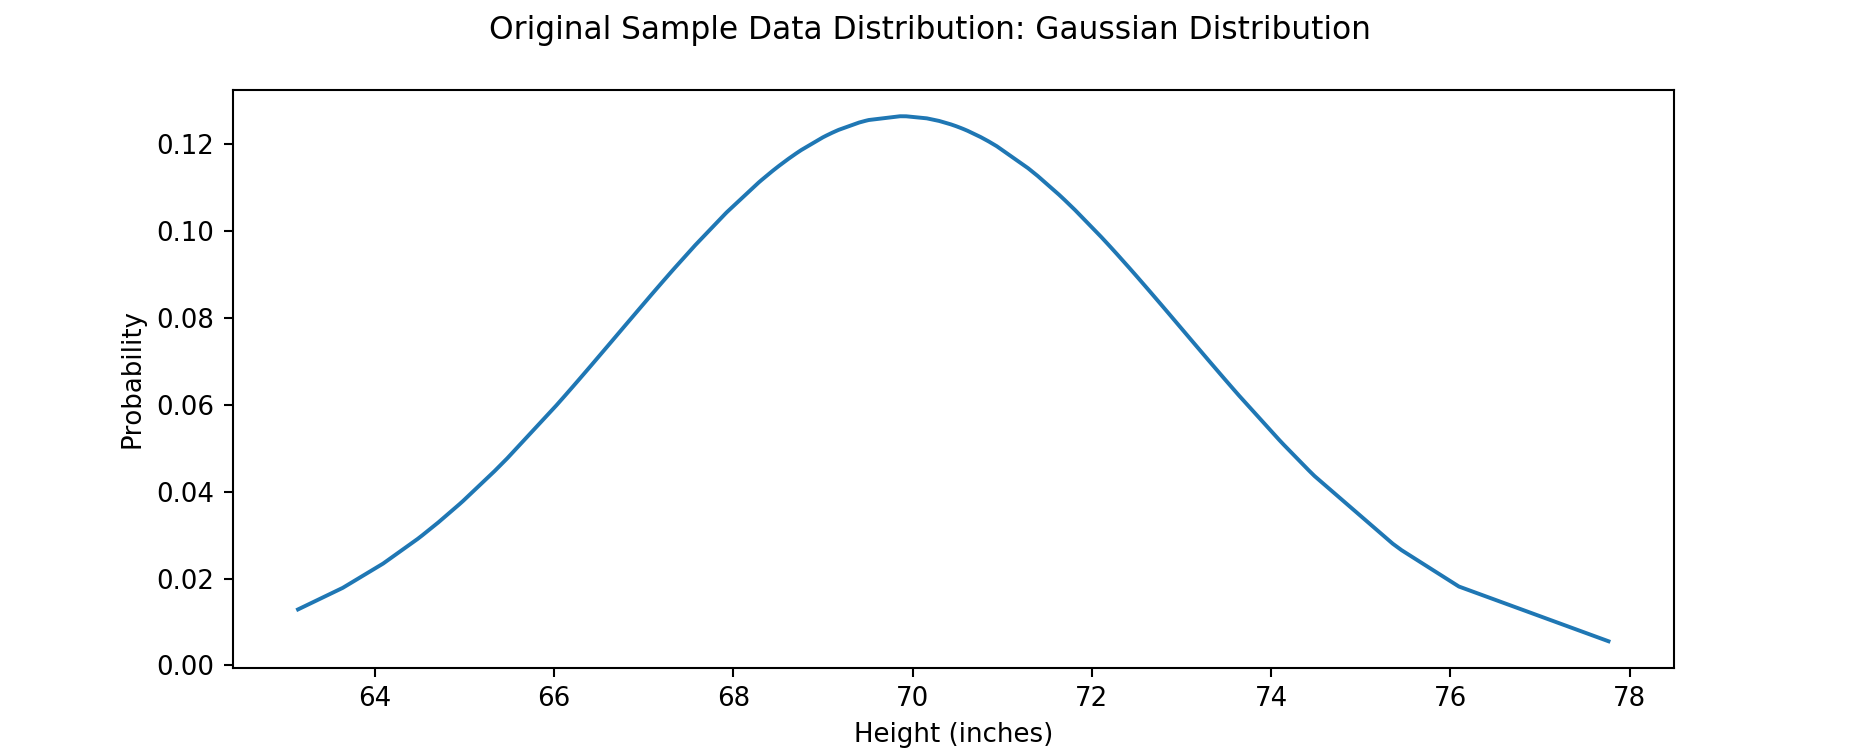

In [851]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Height (inches)');
fig.suptitle('Original Sample Data Distribution: Gaussian Distribution')

visualize_distribution(height_data, ax);

Based on the distribution plot of the original sample data, we can observe that the distribution indeed looks Gaussian. However, the fact that it looks like Gaussian does not matter at all when Bootstrapping, because Bootstrapping does not assume anything about the distribution. 

### 1.A.2 Resampling From the Sample Data

Each Bootstrap resampling (realization) can be done in one-line with [numpy.random.choice()](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html). Each realization is an array of size N, where N is the length of the original sample data. There are M number of realizations, where M is an arbitrary number of your choice. 

** Results **

In [852]:
M = 100                                                 # number of realizations - arbitrary
bootstrap_data = bootstrap_simulation(height_data, M)
bootstrap_data.round(1).head(10)

Real 1  Real 2  Real 3  Real 4  Real 5  Real 6  Real 7  Real 8  Real 9  \
0    66.0    65.5    68.6    68.5    74.1    69.1    69.0    72.9    67.2   
1    69.5    74.1    66.4    66.3    65.3    64.7    71.6    70.8    73.6   
2    72.7    77.8    73.1    66.1    64.9    70.8    73.0    66.8    69.5   
3    72.9    70.6    65.0    71.6    73.6    77.8    73.1    72.7    72.2   
4    69.2    64.5    67.3    74.4    67.1    67.1    66.4    72.5    72.2   
5    73.0    73.5    74.4    68.4    69.5    66.8    73.5    72.2    63.1   
6    73.0    66.6    67.9    70.5    64.5    73.1    72.8    71.4    73.5   
7    68.6    64.9    73.3    69.2    70.6    70.2    70.3    70.3    72.2   
8    68.3    68.7    69.5    69.5    72.7    72.5    72.5    72.8    70.8   
9    73.5    66.2    73.0    69.1    64.9    73.6    74.5    72.9    73.0   

   Real 10    ...     Real 91  Real 92  Real 93  Real 94  Real 95  Real 96  \
0     68.4    ...        65.0     73.5     68.3     69.9     69.1     68.7   
1     69.0    ...        64.1     68.4     66.4     67.2     68.6     74.1   
2     65.5    ...        67.2     66.3     67.9     69.9     64.5     66.1   
3     73.0    ...        66.8     67.6     73.3     66.0     70.8     71.7   
4     68.6    ...        71.6     73.0     72.9     73.5     74.5     72.5   
5     66.1    ...        70.8     72.5     72.7     68.5     67.9     70.5   
6     66.8    ...        73.0     73.1     74.5     70.6     73.5     64.1   
7     72.2    ...        63.6     67.3     74.1     73.6     68.5     69.5   
8     66.4    ...        66.3     71.7     68.3     66.4     67.9     66.4   
9     64.5    ...        67.9     67.1     72.4     71.3     70.8     70.8   

   Real 97  Real 98  Real 99  Real 100  
0     73.0     70.5     69.9      67.3  
1     72.1     67.9     71.6      74.1  
2     70.8     70.8     70.5      70.5  
3     71.6     69.2     68.7      69.9  
4     67.3     69.5     72.3      68.7  
5     70.8     66.6     73.6      67.1  
6     70.9     70.8     68.7      70.6  
7     72.2     72.4     73.6      65.0  
8     70.6     70.2     73.6      74.1  
9     67.1     68.8     65.0      67.9  

[10 rows x 100 columns]

In [853]:
boot_sum_stats = calc_sum_stats(bootstrap_data)
boot_sum_stats.round(1)

Real 1  Real 2  Real 3  Real 4  Real 5  Real 6  Real 7  Real 8  \
mean        69.1    69.6    69.7    69.9    70.1    70.2    70.3    70.1   
std          3.1     3.2     3.3     3.2     2.9     3.2     3.1     3.2   
min         63.1    63.1    63.6    63.1    64.5    64.1    63.6    63.1   
max         76.1    77.8    77.8    77.8    77.8    77.8    77.8    77.8   
median      68.8    69.4    69.1    69.9    70.6    70.2    70.3    70.5   
skew         0.3     0.1     0.2     0.1    -0.2     0.1    -0.0    -0.2   
kurtosis    -0.8    -0.4    -0.8    -0.4    -0.6    -0.6    -0.4    -0.5   
IQR          5.2     5.1     5.4     5.2     4.2     4.7     4.3     4.4   

          Real 9  Real 10    ...     Real 91  Real 92  Real 93  Real 94  \
mean        70.1     69.7    ...        69.8     69.9     69.7     69.6   
std          3.1      3.1    ...         3.1      2.9      3.2      3.5   
min         63.1     63.1    ...        63.1     63.1     63.6     63.1   
max         77.8     77.8    ...        77.8     76.1     77.8     76.1   
median      70.5     70.4    ...        69.4     69.7     69.2     69.2   
skew        -0.2     -0.2    ...         0.2     -0.2      0.1     -0.1   
kurtosis    -0.6     -0.7    ...        -0.5     -0.7     -1.0     -1.0   
IQR          4.9      5.0    ...         5.0      4.2      5.6      5.9   

          Real 95  Real 96  Real 97  Real 98  Real 99  Real 100  
mean         70.0     70.3     69.7     69.7     69.8      69.6  
std           3.3      3.3      3.5      3.1      3.1       3.1  
min          64.1     63.1     63.1     64.1     63.1      63.1  
max          77.8     77.8     77.8     77.8     74.4      77.8  
median       69.7     70.6     70.4     69.9     70.2      69.9  
skew          0.3     -0.1      0.0     -0.0     -0.3      -0.1  
kurtosis     -0.6     -0.4     -1.0     -0.8     -1.1      -0.9  
IQR           5.3      4.9      6.0      5.0      5.3       5.5  

[8 rows x 100 columns]

** Visualize **

<IPython.core.display.Javascript object>


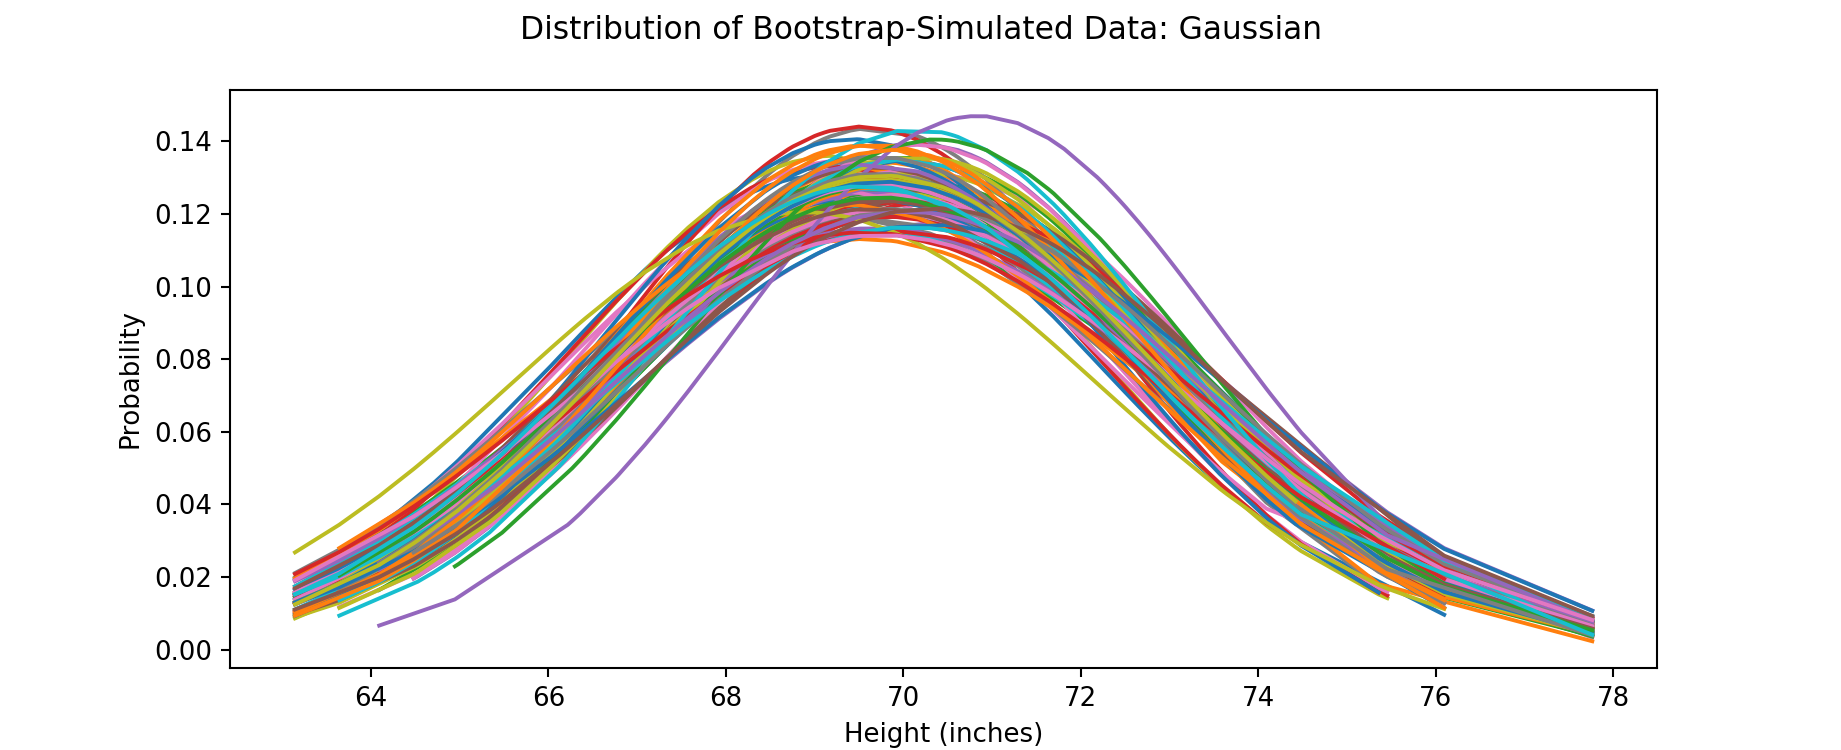

In [854]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Height (inches)');
fig.suptitle('Distribution of Bootstrap-Simulated Data: Gaussian')
visualize_distribution(bootstrap_data, ax);

<div class="alert alert-info">
    <p>Each line in the plot represents one Bootstrap realization. There are 100 realizations, each having 100 random samples.</p> 
</div>

### 1.A.3 Uncertainty Models in Summary Statistics with Blox Plots

<IPython.core.display.Javascript object>


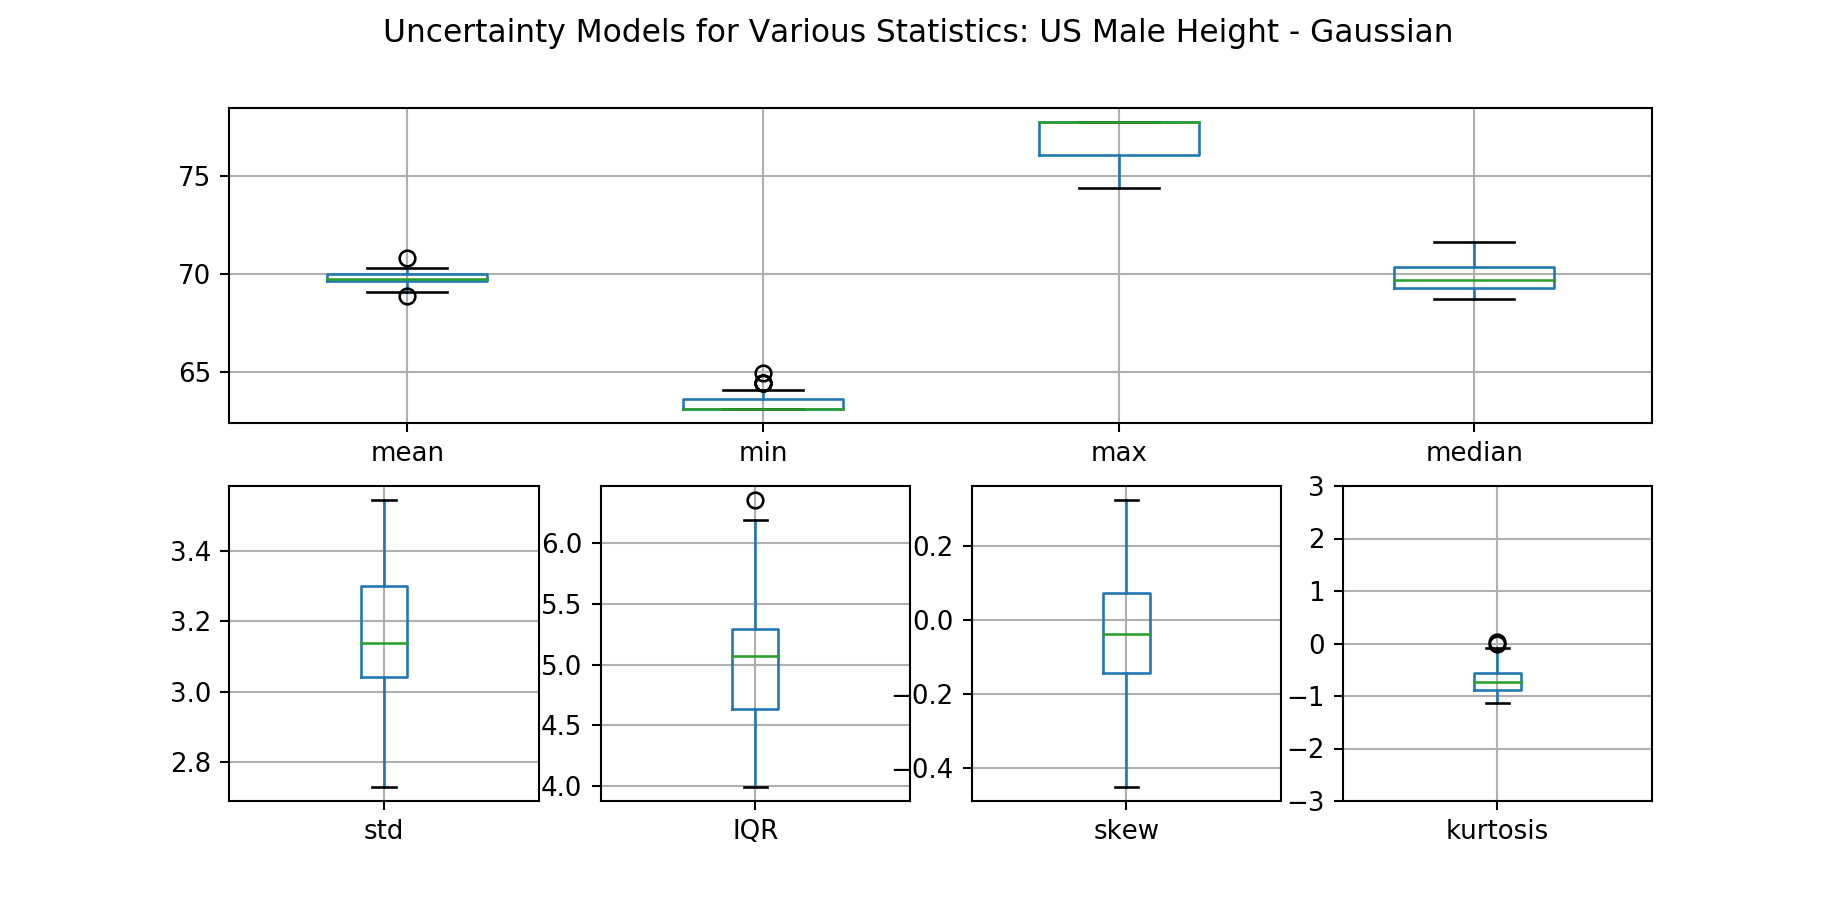

In [865]:
f = plt.figure()
plt.suptitle('Uncertainty Models for Various Statistics: US Male Height - Gaussian')

gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0, 0:4])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[1, 2])
ax5 = plt.subplot(gs[1, 3])

boot_sum_stats.T[['mean', 'min', 'max', 'median']].boxplot(ax=ax1)
boot_sum_stats.T[['std']].boxplot(ax=ax2)
boot_sum_stats.T[['IQR']].boxplot(ax=ax3)
boot_sum_stats.T[['skew']].boxplot(ax=ax4)
boot_sum_stats.T[['kurtosis']].boxplot(ax=ax5)

ax5.set_ylim([-3, 3])
ax6.set_ylim([-10, 10]);

### 1.A.4 Confidence Interval in Summary Statistics

Confidence intervals of summary statistics usually have a confidence level of 90%, 95%, or 99%. In this case, we will choose **95% confidence level**. 

In [857]:
confidence_level = 0.95

conf_int = calc_confidence_interval(boot_sum_stats, confidence_level)
conf_int.round(1)

P2.5   P50  P97.5
mean      69.2  69.8   70.3
std        2.8   3.1    3.5
min       63.1  63.1   64.5
max       75.4  77.8   77.8
median    69.0  69.7   70.6
skew      -0.4  -0.0    0.3
kurtosis  -1.1  -0.7   -0.2
IQR        4.1   5.1    6.0

In [858]:
print_confidence_interval(conf_int, confidence_level)

By 95.0% chance, the following statistics will fall within the range of:

mean      :       69.2  ~       70.3 , AVG =  69.8
std       :        2.8  ~        3.5 , AVG =   3.1
min       :       63.1  ~       64.5 , AVG =  63.1
max       :       75.4  ~       77.8 , AVG =  77.8
median    :       69.0  ~       70.6 , AVG =  69.7
skew      :       -0.4  ~        0.3 , AVG =  -0.0
kurtosis  :       -1.1  ~       -0.2 , AVG =  -0.7
IQR       :        4.1  ~        6.0 , AVG =   5.1


## 1.B. Confidence Intervals in Summary Stats: Rock Permeability - Lognormal Distribution



It was previously stated that Bootstrapping does not assume anything about the distribution. Is that really true? The previous example of the US Male Height distribution was a Gaussian distribution. But what if the distribution of our interest is not Gaussian? 

In this example, rock pearmeability, which has a **lognormal distribution**, will be used to show that Bootstrap does not depend on the type of the distribution. 

### 1.B.0. Bootstrap Scripts

The sample scripts used for US Male Height example will be used for Bootstrap simulation. Same scripts can be used for both Gaussian and lognormal distribution because Bootstrapping does not assume anything about the distribution.

### 1.B.1. Sample Data Description

105 samples of permeability data is provided in **sample_data/PoroPermSampleData.xlsx**. Permeability data is taken at many times at different depth of a wellbore.

Summary statistics of the sample data can be calculated. Your goal is to calculate the confidence intervals for the summary stats. 

<IPython.core.display.Javascript object>


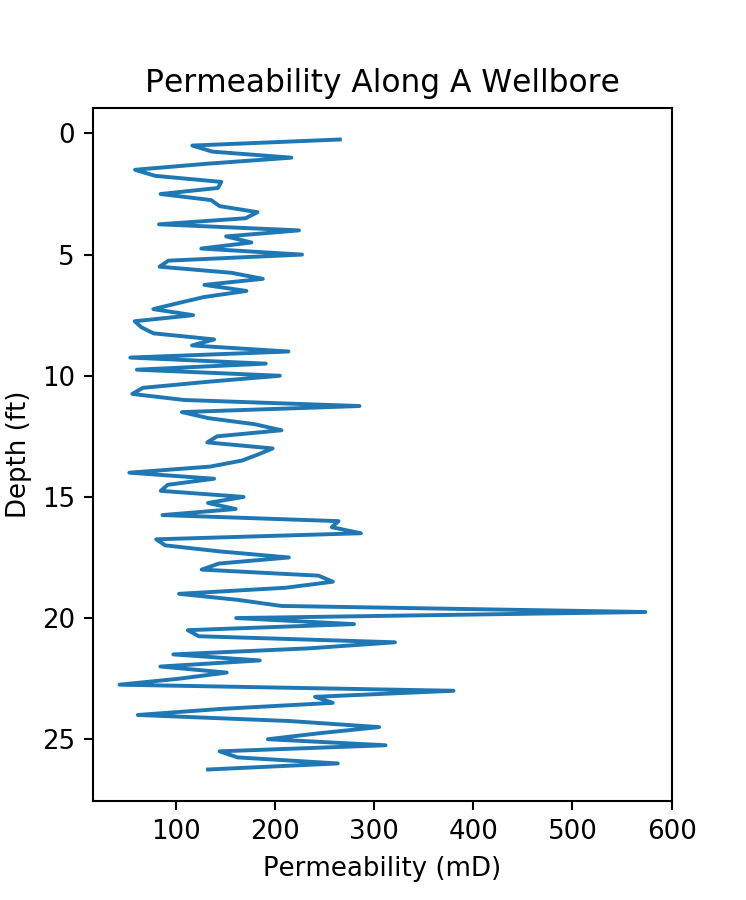

In [830]:
# permeability data
perm_depth_data = pd.read_excel('sample_data/PoroPermSampleData.xlsx', sheet_name='Sheet1')[['Depth', 'Permeability (mD)']]
perm_data = perm_depth_data['Permeability (mD)'].to_frame()

# visualize
fig = plt.figure()
ax = plt.axes()

ax.plot(perm_depth_data['Permeability (mD)'], perm_depth_data['Depth']);
ax.invert_yaxis()
ax.set_title('Permeability Along A Wellbore')
ax.set_xlabel('Permeability (mD)')
ax.set_ylabel('Depth (ft)');

In [859]:
perm_summary_stats = calc_sum_stats(perm_data)
perm_summary_stats

Permeability (mD)
mean             161.008972
std               80.900128
min               43.534147
max              573.461883
median           144.329837
skew               1.625086
kurtosis           5.498080
IQR              102.580432

** Visualization **

<IPython.core.display.Javascript object>


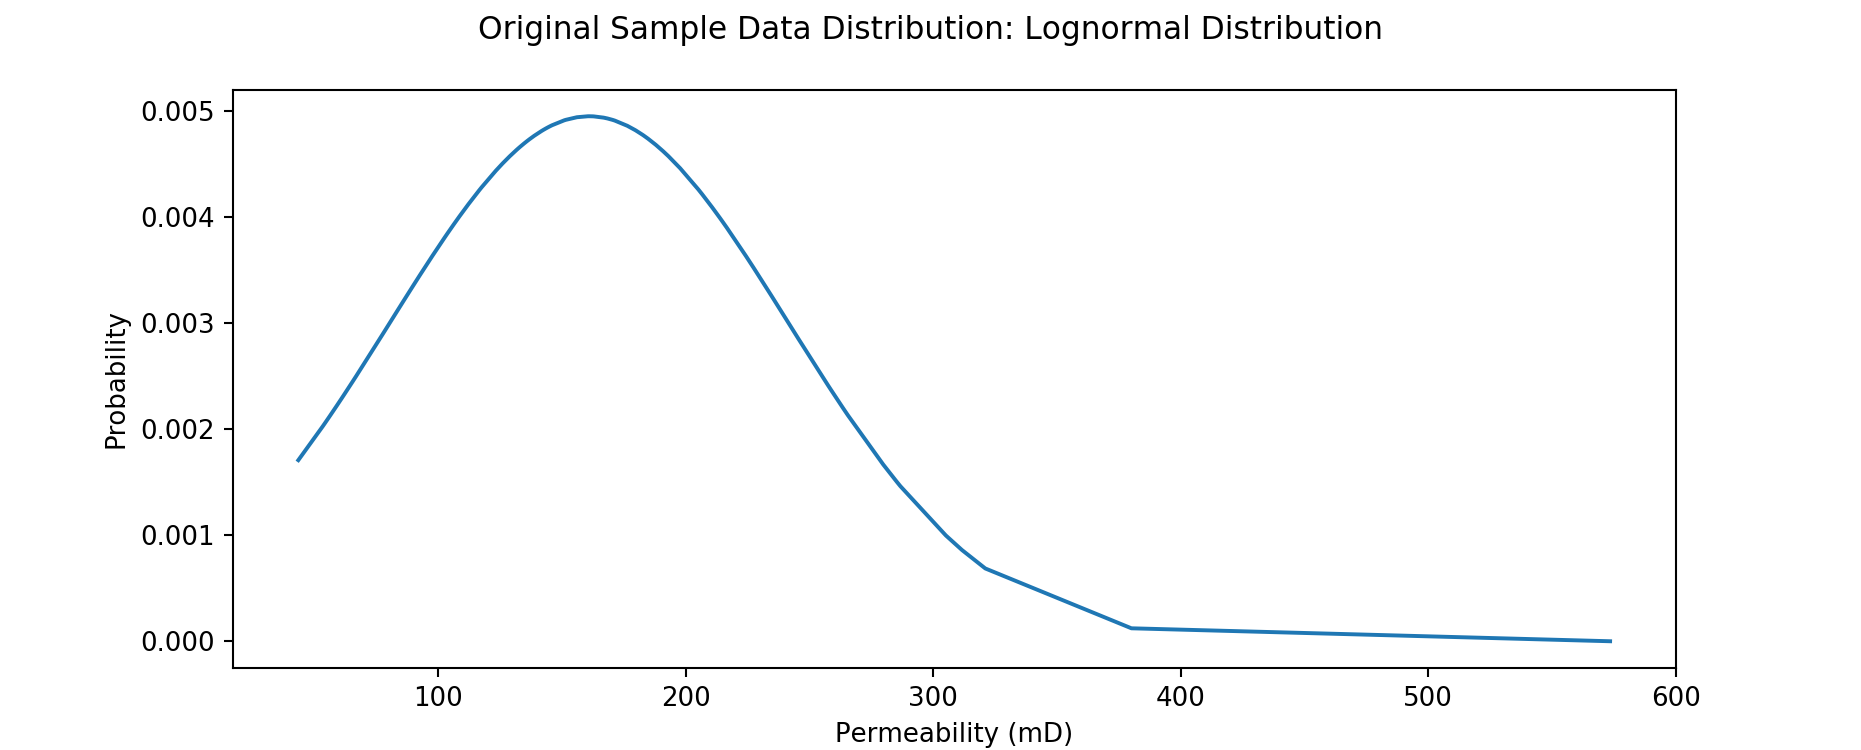

In [699]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel('Permeability (mD)')
fig.suptitle('Original Sample Data Distribution: Lognormal Distribution')
visualize_distribution(perm_data, ax);

Based on the distribution of the original sample data, we can observe that the distribution looks lognormal. The uncertainty in summary statistics can be calculated using Bootstrap the same way it was done for the US Male Height (Gaussian) distribution, because Bootstrap does not depend on the shape of the distribution.

<div class="alert alert-info">
    <h4>Warning!</h4>
    <p>Outlier removal on rock permeability cannot be done directly, as this is a lognormal distribution. Recall that the typical outlier removal method assumes the distribution to be Gaussian. If you want to detect outliers for non-Gaussian distributions, you have to first transform the distribution into Gaussian.</p>
</div>

### 1.B.2 Resampling From the Sample Data

Each Bootstrap resampling (realization) can be done in one-line with [numpy.random.choice()](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html). Each realization is an array of size N, where N is the length of the original sample data. There are M number of realizations, where M is an arbitrary number of your choice. 

** Results **

In [860]:
M = 100                      # number of realizations - arbitrary
boot_perm_data = bootstrap_simulation(perm_data, M)
boot_perm_data.round(1).head(10)

Real 1  Real 2  Real 3  Real 4  Real 5  Real 6  Real 7  Real 8  Real 9  \
0   179.7   168.4   132.7   123.3   258.4   116.9   144.4   170.5   144.7   
1   132.7    58.8   166.9   206.6   216.7   258.4    53.4   286.8   117.6   
2    83.9   286.8    79.4   103.5    80.4   138.8   170.5    97.7   138.8   
3   131.6   187.9   311.6   125.9    80.4    85.0   131.6   190.9   132.7   
4    43.5   142.7    77.8   142.7   123.3    59.1   151.0    58.8    61.0   
5    56.3   134.7    86.8   279.8   143.7   279.8   263.5    92.1   133.2   
6   102.7    84.7   162.3    77.8   265.5   179.7    77.8   141.8   106.4   
7   214.9   224.4   311.6   321.1    86.8    79.4   116.9   187.9   210.8   
8   171.4    54.3   244.1   151.5   126.3   136.9   136.9   258.4    58.8   
9   171.4    84.7   227.4   240.6   135.8   128.9   162.3   244.1   116.6   

   Real 10    ...     Real 91  Real 92  Real 93  Real 94  Real 95  Real 96  \
0    141.8    ...        56.3    128.9    224.4    205.1     77.8    210.8   
1    168.4    ...       145.6    264.2     58.8     84.7    213.7     84.9   
2    265.5    ...       227.4     89.6    257.4    133.2    162.9     58.8   
3    214.9    ...       125.9    108.6     92.7    129.1    134.7    131.6   
4    193.1    ...       216.7    132.7    116.9    160.5    161.0    573.5   
5     53.4    ...        58.8    206.6     84.7    117.6     85.0     61.9   
6     61.0    ...        43.5     61.9    234.5    132.1    258.4    131.6   
7    144.4    ...       234.5    234.5     77.5    144.7    179.7    123.3   
8     83.3    ...       213.7    205.1    286.8    112.3    216.7    145.6   
9    161.0    ...       125.9     77.5    240.6     92.7    123.3    258.6   

   Real 97  Real 98  Real 99  Real 100  
0     83.3     84.9    138.8     184.8  
1    214.9    108.6    126.3     213.7  
2    227.4    116.6    141.8     210.8  
3    135.8    224.4    104.0     234.5  
4    146.0    156.1    183.1     143.7  
5    112.3     83.9    128.9     162.3  
6    146.0    285.3     80.4     116.6  
7    184.8    214.1    265.5     170.5  
8     59.1    117.6    106.4      80.4  
9    227.4    102.7    141.8     380.1  

[10 rows x 100 columns]

In [861]:
boot_perm_sum_stats = calc_sum_stats(boot_perm_data)
boot_perm_sum_stats.round(1)

Real 1  Real 2  Real 3  Real 4  Real 5  Real 6  Real 7  Real 8  \
mean       154.3   154.3   165.7   168.1   161.8   159.8   165.2   159.9   
std         66.8    67.4    84.1    91.6    78.5    73.7    85.7    83.1   
min         43.5    43.5    43.5    43.5    53.4    53.4    53.4    43.5   
max        380.1   380.1   573.5   573.5   573.5   573.5   573.5   573.5   
median     144.3   143.7   151.0   144.4   144.3   144.4   144.4   142.7   
skew         0.7     1.0     1.3     1.8     1.7     1.9     1.6     1.5   
kurtosis     0.5     1.2     3.9     5.6     6.3     8.3     4.4     4.5   
IQR         80.8    81.6   111.4   113.2    90.1    80.9    90.1   121.1   

          Real 9  Real 10    ...     Real 91  Real 92  Real 93  Real 94  \
mean       152.7    170.9    ...       173.8    158.4    166.7    156.7   
std         70.5     69.9    ...       100.3     66.0     84.5     75.1   
min         43.5     53.4    ...        43.5     54.3     53.4     43.5   
max        380.1    380.1    ...       573.5    321.1    573.5    573.5   
median     138.8    162.9    ...       144.7    144.7    151.0    141.8   
skew         0.9      0.5    ...         1.9      0.4      1.4      2.1   
kurtosis     0.9      0.2    ...         5.4     -0.6      4.1      8.4   
IQR         86.7     85.2    ...       100.1     92.8    111.4     91.4   

          Real 95  Real 96  Real 97  Real 98  Real 99  Real 100  
mean        166.1    149.5    153.1    163.7    152.6     156.9  
std          65.2     82.4     78.1     81.5     71.9      71.6  
min          43.5     54.3     53.4     43.5     43.5      53.4  
max         380.1    573.5    573.5    380.1    573.5     380.1  
median      156.1    132.0    136.9    144.4    141.8     143.7  
skew          0.8      2.0      1.8      0.7      2.1       0.9  
kurtosis      0.4      6.6      6.8     -0.2     10.1       0.4  
IQR          80.8     98.0    121.1    121.7     86.9      88.2  

[8 rows x 100 columns]

** Visualize **

<IPython.core.display.Javascript object>


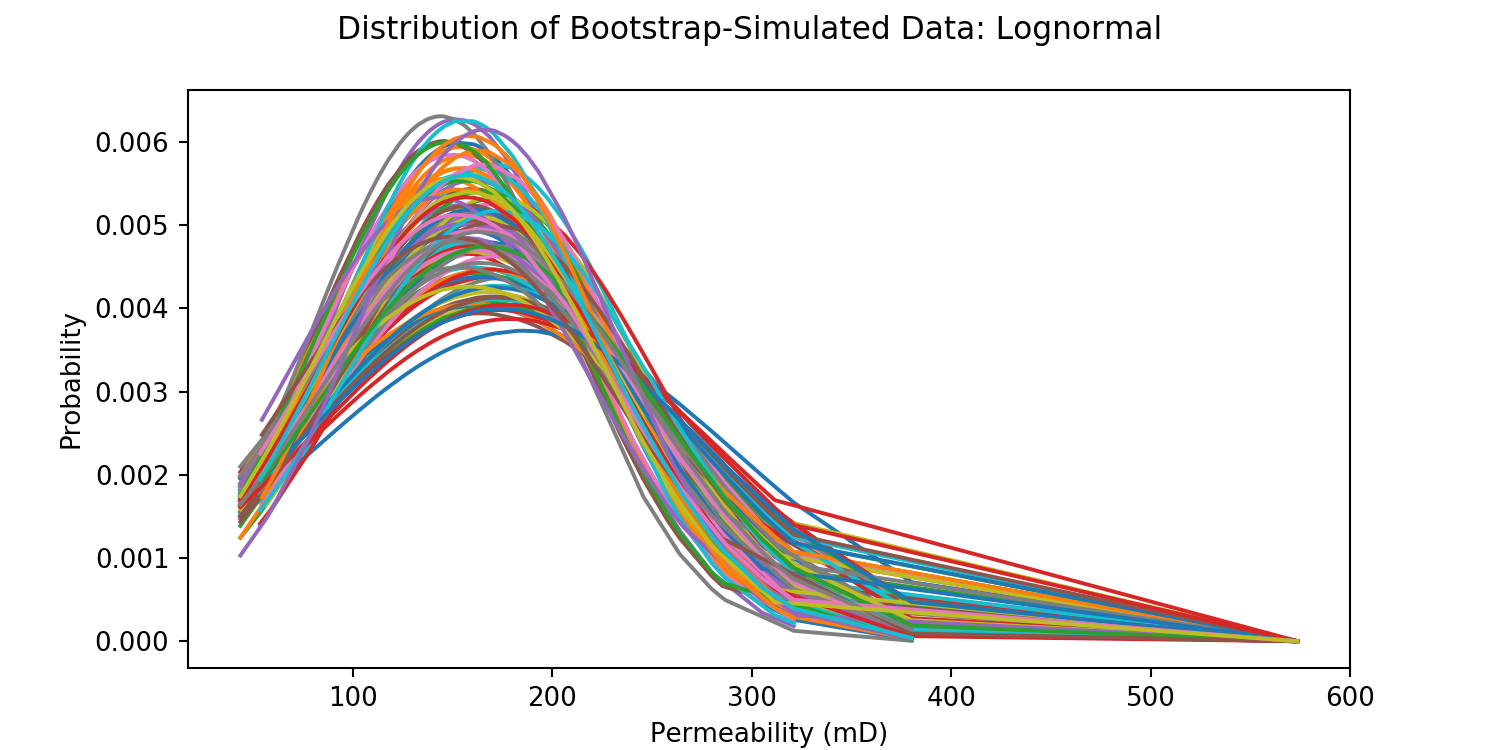

In [862]:
fig, ax = plt.subplots(figsize=(8, 4))
fig.suptitle('Distribution of Bootstrap-Simulated Data: Lognormal')
ax.set_xlabel('Permeability (mD)')
visualize_distribution(boot_perm_data, ax);

### 1.B.3 Uncertainty Models in Summary Statistics with Blox Plots

<IPython.core.display.Javascript object>


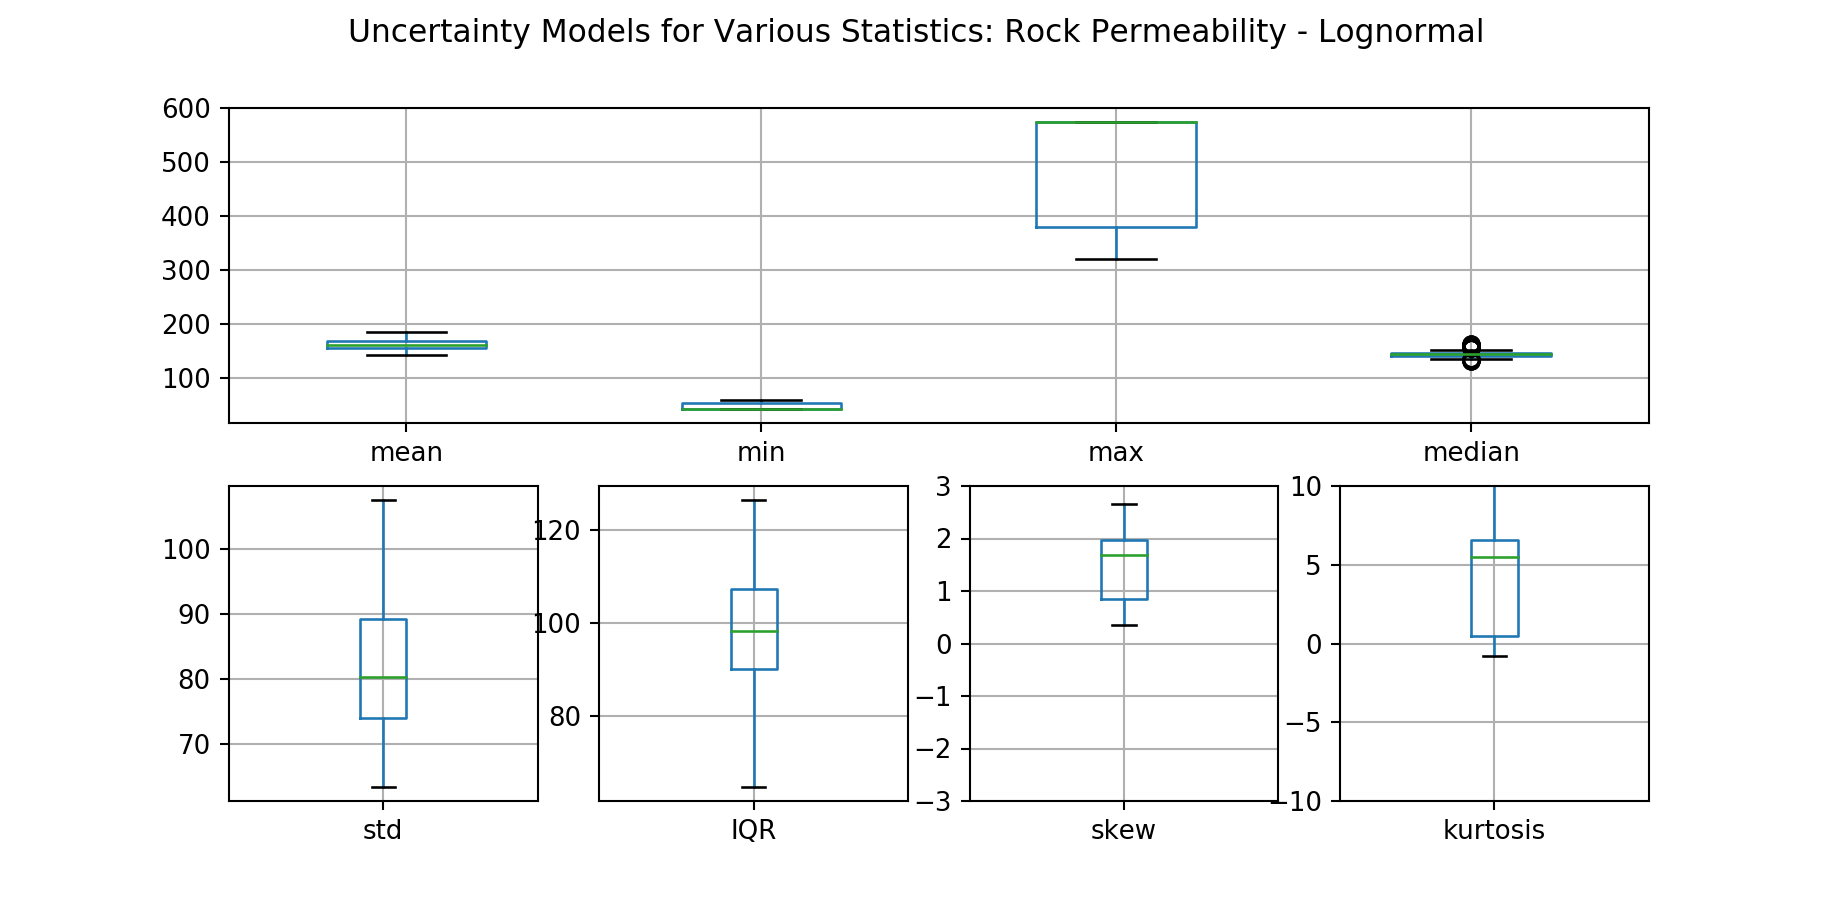

In [864]:
f = plt.figure()
plt.suptitle('Uncertainty Models for Various Statistics: Rock Permeability - Lognormal')

gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0, 0:4])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[1, 2])
ax5 = plt.subplot(gs[1, 3])

boot_perm_sum_stats.T[['mean', 'min', 'max', 'median']].boxplot(ax=ax1)
boot_perm_sum_stats.T[['std']].boxplot(ax=ax2)
boot_perm_sum_stats.T[['IQR']].boxplot(ax=ax3)
boot_perm_sum_stats.T[['skew']].boxplot(ax=ax4)
boot_perm_sum_stats.T[['kurtosis']].boxplot(ax=ax5)

ax4.set_ylim([-3, 3])
ax5.set_ylim([-10, 10]);

Observe the **positive skewness** in the boxplot summary statistics. This is consistent with the left-justified lognormal distribution of the permeability plot.

### 1.B.4 Confidence Interval in Summary Statistics

Confidence intervals of summary statistics usually have a confidence level of 90%, 95%, or 99%. In this case, we will choose **90% confidence level**.

In [836]:
confidence_level = 0.9

conf_int_perm = calc_confidence_interval(boot_perm_sum_stats, confidence_level)
conf_int_perm.round(1)

P5.0     P50   P95.0
mean       149.9   161.4   171.2
std         64.3    79.9    97.6
min         43.5    43.5    56.3
max        311.6   573.5   573.5
variance  4129.3  6387.1  9528.9
skew         0.4     1.5     2.3
kurtosis    -0.7     4.9     8.4
IQR         74.3    98.1   121.8

In [837]:
print_confidence_interval(conf_int_perm, confidence_level)

By 90.0% chance, the following statistics will fall within the range of:

mean      :      149.9  ~      171.2 , AVG = 161.4
std       :       64.3  ~       97.6 , AVG =  79.9
min       :       43.5  ~       56.3 , AVG =  43.5
max       :      311.6  ~      573.5 , AVG = 573.5
variance  :     4129.3  ~     9528.9 , AVG = 6387.1
skew      :        0.4  ~        2.3 , AVG =   1.5
kurtosis  :       -0.7  ~        8.4 , AVG =   4.9
IQR       :       74.3  ~      121.8 , AVG =  98.1
